# 시퀀스를 예측하는 머신러닝 모델 만들기

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 윈도 데이터셋 만들기

In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True) # 5개의 항목으로 구성된 윈도, shift = 1로 지정하면 윈도가 이전 위치에서 한 항목씩 이동함.
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


2024-08-14 22:24:38.018681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


2024-08-14 22:24:38.045836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[5 6 7 8]
 [0 1 2 3]]
y =  [[9]
 [4]]
x =  [[4 5 6 7]
 [2 3 4 5]]
y =  [[8]
 [6]]
x =  [[3 4 5 6]
 [1 2 3 4]]
y =  [[7]
 [5]]


2024-08-14 22:24:38.075572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 윈도를 적용한 시계열 데이터셋 만들기

In [10]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [12]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, 
                           shuffle_buffer_size)

In [13]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
    print(feature)
    print(label)

tf.Tensor(
[[62.674374 54.582493 59.79131  55.536667 63.192192 65.10124  73.45097
  66.763306 64.0933   69.39621  54.25413  66.54874  69.28609  58.10017
  71.273445 67.30896  63.602074 68.904686 77.15672  66.775314]], shape=(1, 20), dtype=float32)
tf.Tensor([67.17002], shape=(1,), dtype=float32)


2024-08-14 22:24:38.195076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### DNN을 만들고 시퀀스 데이터로 훈련하기

In [14]:
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

/Users/gugo-le/Desktop/DEV/python projects/school record/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse",optimizer=sgd)

In [16]:
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100


2024-08-14 22:30:47.005770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3993.1143
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93.5542
Epoch 3/100


2024-08-14 22:30:49.317449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:49.317461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:49.317467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:49.317470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-14 22:30:49.317473: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8903708440498099957
2024-08-14 22:30:49.317492: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
/Library/

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72.3528
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.5254
Epoch 5/100


2024-08-14 22:30:49.670648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:49.670662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:49.670667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:49.670671: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:49.670674: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:49.670678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 70.4113
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.1625
Epoch 7/100


2024-08-14 22:30:50.075831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:50.075849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:50.075853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:50.075857: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:50.075861: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:50.075865: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.2466
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.2238
Epoch 9/100


2024-08-14 22:30:50.427266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:50.427280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:50.427285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:50.427289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:50.427292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:50.427296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.8546
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.7314
Epoch 11/100


2024-08-14 22:30:50.781397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:50.781411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:50.781415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:50.781419: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:50.781422: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:50.781426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.2632
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.3172
Epoch 13/100


2024-08-14 22:30:51.126044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:51.126059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:51.126063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:51.126067: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:51.126071: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:51.126074: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.3119
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.0043
Epoch 15/100


2024-08-14 22:30:51.474834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:51.474850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:51.474858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:51.474862: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:51.474865: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:51.474868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61.7577
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.3321
Epoch 17/100


2024-08-14 22:30:51.812763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:51.812774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:51.812779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:51.812783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:51.812786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:51.812789: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.0335
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.2469
Epoch 19/100


2024-08-14 22:30:52.143563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:52.143575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:52.143580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:52.143583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:52.143587: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:52.143591: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.6764
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.8805
Epoch 21/100


2024-08-14 22:30:52.473019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:52.473033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:52.473038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:52.473042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:52.473045: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:52.473049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.5411
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.3967
Epoch 23/100


2024-08-14 22:30:52.802267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:52.802282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:52.802286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:52.802290: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:52.802294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:52.802299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.0663
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.2224
Epoch 25/100


2024-08-14 22:30:53.129289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:53.129304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:53.129309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:53.129313: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:53.129316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:53.129320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.3055
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.8999
Epoch 27/100


2024-08-14 22:30:53.459305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:53.459319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:53.459323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:53.459327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:53.459331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:53.459334: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.1901
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.4657
Epoch 29/100


2024-08-14 22:30:53.785812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:53.785830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:53.785834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:53.785838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:53.785841: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:53.785844: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 55.5750
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.5991
Epoch 31/100


2024-08-14 22:30:54.167214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:54.167230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:54.167235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:54.167239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:54.167242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:54.167246: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.1861
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.8608
Epoch 33/100


2024-08-14 22:30:54.504147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:54.504162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:54.504167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:54.504171: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:54.504178: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:54.504182: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.6151
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52.3933
Epoch 35/100


2024-08-14 22:30:54.851190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:54.851203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:54.851208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:54.851211: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:54.851214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:54.851217: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52.0583
Epoch 36/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 50.1271

2024-08-14 22:30:55.226460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:55.226473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:55.226478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:55.226482: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:55.226485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:55.226488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 50.7174
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.6177
Epoch 38/100


2024-08-14 22:30:55.526332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:55.526348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/mod/_15]]
2024-08-14 22:30:55.526356: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
2024-08-14 22:30:55.526359: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:55.526363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:55.526366: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancell

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.3174
Epoch 39/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 58.7298  

2024-08-14 22:30:55.947909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:55.947925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:55.947929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:55.947933: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:55.947935: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:55.947939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.6128
Epoch 40/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52.0942

2024-08-14 22:30:56.206756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:56.206770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:56.206775: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:56.206779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:56.206782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:56.206785: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 51.5977
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.2502
Epoch 42/100


2024-08-14 22:30:56.415395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:56.415409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:56.415419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:56.415423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:56.415426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:56.415429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 48.9091
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.6141
Epoch 44/100


2024-08-14 22:30:56.975134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:56.975147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:56.975151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:56.975155: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:56.975158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:56.975161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.3141
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.5384
Epoch 46/100


2024-08-14 22:30:57.299055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:57.299067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:57.299072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:57.299075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:57.299079: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:57.299082: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.4485
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.4735
Epoch 48/100


2024-08-14 22:30:57.621521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:57.621534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:57.621538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:57.621543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:57.621547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:57.621551: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.4419
Epoch 49/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.2976

2024-08-14 22:30:58.014216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:58.014228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:58.014233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:58.014237: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:58.014240: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:58.014243: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 50.4590
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.5036
Epoch 51/100


2024-08-14 22:30:58.302308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:58.302323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:58.302328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:58.302331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:58.302334: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:58.302337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.5391
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.6784
Epoch 53/100


2024-08-14 22:30:58.637407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:58.637419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:58.637423: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:58.637427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:58.637430: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:58.637433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.8179
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.3172
Epoch 55/100


2024-08-14 22:30:58.982012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:58.982026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/mod/_15]]
2024-08-14 22:30:58.982034: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
2024-08-14 22:30:58.982039: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:58.982043: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:58.982046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancell

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.2033
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.1544
Epoch 57/100


2024-08-14 22:30:59.325340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:59.325354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:30:59.325358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:30:59.325363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:59.325366: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:59.325369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.8905
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.2010
Epoch 59/100


2024-08-14 22:30:59.665270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:30:59.665285: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
2024-08-14 22:30:59.665289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:30:59.665292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:30:59.665295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-14 22:30:59.665298: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8903708440498099957
2024-08-14 22:30:59.665305: W tensorflow/core/framework/local_rendezv

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.0512
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.8998
Epoch 61/100


2024-08-14 22:31:00.004386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:00.004402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:00.004407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:00.004411: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:00.004414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:00.004418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.5405
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.2947
Epoch 63/100


2024-08-14 22:31:00.337853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:00.337871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:00.337880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:00.337884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:00.337891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:00.337895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.1819
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.2581
Epoch 65/100


2024-08-14 22:31:00.722044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:00.722058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:00.722062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:00.722066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:00.722069: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:00.722073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.1423
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.7391
Epoch 67/100


2024-08-14 22:31:01.051307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:01.051320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
2024-08-14 22:31:01.051324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:01.051328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mse/mod/_15]]
2024-08-14 22:31:01.051344: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:01.051354: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancell

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.4323
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.3671
Epoch 69/100


2024-08-14 22:31:01.390818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:01.390832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:01.390836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:01.390839: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:01.390842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:01.390845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.3026
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.6584
Epoch 71/100


2024-08-14 22:31:01.717453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:01.717465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:01.717470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:01.717474: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:01.717477: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:01.717482: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.1672
Epoch 72/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.6178  

2024-08-14 22:31:02.046557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:02.046569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:02.046573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:02.046577: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:02.046581: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:02.046586: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.9971
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.7328
Epoch 74/100


2024-08-14 22:31:02.265392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:02.265405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:02.265410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:02.265414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:02.265417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:02.265420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.2299
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.8602
Epoch 76/100


2024-08-14 22:31:02.597083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:02.597096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:02.597101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:02.597104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:02.597108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:02.597111: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.2069
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.6533
Epoch 78/100


2024-08-14 22:31:02.925041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:02.925055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:02.925059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:02.925064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:02.925068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:02.925072: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.1298
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.5780
Epoch 80/100


2024-08-14 22:31:03.261687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:03.261701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:03.261705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:03.261709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:03.261712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:03.261716: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.5480
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.6536
Epoch 82/100


2024-08-14 22:31:03.591648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:03.591663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:03.591667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:03.591671: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:03.591674: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:03.591678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.1271
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.2317
Epoch 84/100


2024-08-14 22:31:03.918559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:03.918574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:03.918578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:03.918582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:03.918585: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:03.918588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.3542
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.5993
Epoch 86/100


2024-08-14 22:31:04.245731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:04.245745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:04.245750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:04.245754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:04.245757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:04.245761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.5652
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.0296
Epoch 88/100


2024-08-14 22:31:04.573232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:04.573246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:04.573250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:04.573254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:04.573258: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:04.573262: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.0689
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.8782
Epoch 90/100


2024-08-14 22:31:04.903267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:04.903282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:04.903287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:04.903291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:04.903295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:04.903299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.5254
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.3304
Epoch 92/100


2024-08-14 22:31:05.230399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:05.230412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:05.230417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:05.230421: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:05.230424: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:05.230428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.7907
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.1211
Epoch 94/100


2024-08-14 22:31:05.557135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:05.557151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:05.557155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:05.557159: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:05.557163: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:05.557167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.9421
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.5889
Epoch 96/100


2024-08-14 22:31:05.885085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:05.885099: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
2024-08-14 22:31:05.885102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:05.885106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:05.885109: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:05.885112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-14 22:31:05.885116: I tensorflow/core/framework/local_rendez

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.2066
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.1802
Epoch 98/100


2024-08-14 22:31:06.299529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:06.299544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:06.299548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:06.299552: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:06.299555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:06.299559: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.7329
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.5199
Epoch 100/100


2024-08-14 22:31:06.628707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:06.628722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 22:31:06.628727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:31:06.628732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:31:06.628735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:31:06.628739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14093090795677756463
2024-08-1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.4346


2024-08-14 22:31:06.974810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:31:06.974827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
2024-08-14 22:31:06.974832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8903708440498099957
2024-08-14 22:31:06.974858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]


### DNN의 결과 평가하기

In [17]:
print(series[1000:1020])

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]


In [18]:
print(series[1020])

106.258606


In [19]:
print(model.predict(series[1000:1020][np.newaxis]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
[[100.06052]]


In [20]:
start_point = 1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(
      series[start_point:start_point+window_size][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[100.06052]]


### 전반적인 예측 살펴보기

In [21]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━

In [22]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [23]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

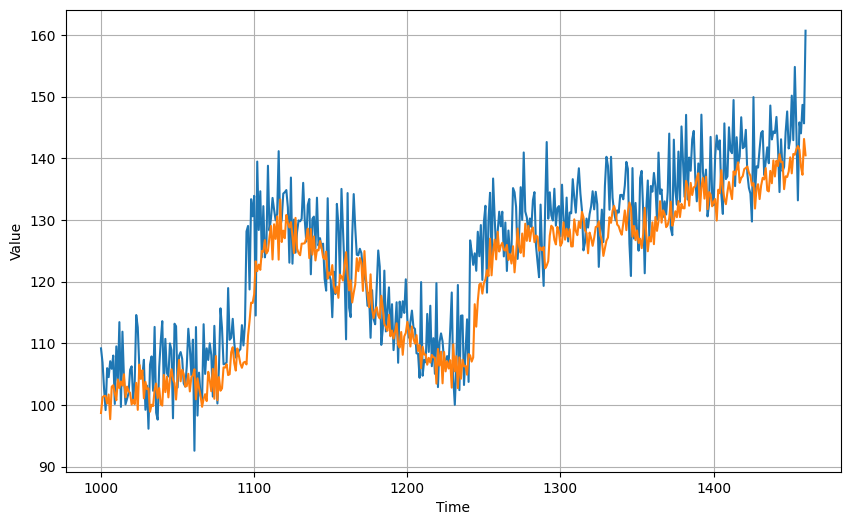

In [24]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [28]:
# Metric 객체 생성
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# 상태 업데이트
mae_metric.update_state(x_valid, results)

# 결과 출력
print(mae_metric.result().numpy())


5.4988713


### 학습률 튜닝하기

In [29]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, 
                    callbacks=[lr_schedule], verbose=0)

2024-08-14 22:40:07.657167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-14 22:40:07.657187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17009575246217841942
2024-08-14 22:40:07.657190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 11585343428089294889
2024-08-14 22:40:07.657194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9021480330311347017
2024-08-14 22:40:07.657197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8679857308113570859
2024-08-14 22:40:07.657200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradie

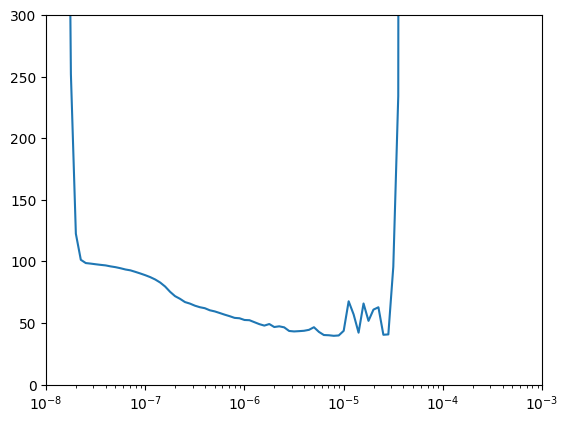

In [31]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()